# assigment

## EDA

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [121]:
# read data
X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

# merge to have the dataset in one dataframe
data = pd.concat([X, Y], axis=1)

/tmp/ipykernel_45423/2748754953.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
/tmp/ipykernel_45423/2748754953.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)


In [122]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V1991,V1992,V1993,V1994,V1995,V1996,V1997,V1998,V1999,V2000
1,-1.168003,1.261756,-1.534537,-0.156028,-0.700344,3.985627,2.432774,0.767859,1.225563,-0.198581,...,-0.015099,-0.217915,0.123574,-3.209894,-1.26123,-1.676247,-0.8625,-1.103947,-1.109631,0.43515
2,-3.272103,-0.269244,-1.534537,-0.679228,-0.947544,0.794827,0.067374,0.033459,-0.010137,-0.198581,...,0.285601,-0.155615,1.044074,-3.209894,-2.37073,1.973753,-1.9055,-1.103947,-1.109631,0.89295
3,-0.861503,-0.189544,-1.534537,0.010572,-0.268144,1.808827,1.273274,-0.501841,0.753163,-0.198581,...,-1.816599,-0.217015,0.023974,-3.209894,-0.27183,0.245753,-1.2135,-1.103947,-1.109631,-0.45655
4,-0.595803,-0.580044,-1.534537,-0.107828,-0.475644,0.738027,-1.945726,0.476859,-0.010137,-0.198581,...,-0.532399,-0.402215,-0.410726,-3.209894,0.36967,1.586153,-0.5700,-1.103947,1.215569,0.45415
5,1.336097,0.360556,-1.534537,-0.097728,0.359656,-0.940173,0.378774,-0.271741,-0.010137,-0.198581,...,-0.894799,0.043385,0.273874,-0.747594,-0.46893,-0.481547,0.6180,-1.103947,-0.392031,-0.88775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,-2.407703,-0.630444,-1.534537,-0.746028,-0.615444,2.733027,-2.976926,0.433959,-0.010137,-0.198581,...,-1.537899,0.185685,-1.025226,2.214606,-0.20143,4.214753,-2.8351,2.170853,-1.109631,0.21915
2884,0.626397,0.546456,-1.534537,0.291672,1.228856,1.607627,-0.696826,-0.359341,-0.010137,-0.198581,...,-3.281399,-0.248515,-0.691026,0.352406,0.52507,3.099053,-2.4853,-1.103947,1.709069,-1.31475
2885,-0.247003,1.178056,-1.534537,-0.232828,1.647956,3.450627,-0.517526,0.094659,-0.010137,-0.198581,...,-2.792999,-0.121515,-0.475626,1.095506,-1.49993,3.473553,2.9253,-1.103947,1.492969,-0.15755
2886,-0.765003,-0.291644,-0.409837,-0.533628,2.256756,1.657427,-3.786426,-2.083541,-0.010137,-0.198581,...,0.963001,-0.013315,0.250774,0.400806,-0.51443,3.139053,-2.9320,-1.103947,-1.109631,0.11055


In [123]:
Y

,x
1,GBM
2,GBM
3,GBM
4,GBM
5,GBM
...,...
2883,U
2884,U
2885,U
2886,U


<Axes: xlabel='x', ylabel='count'>

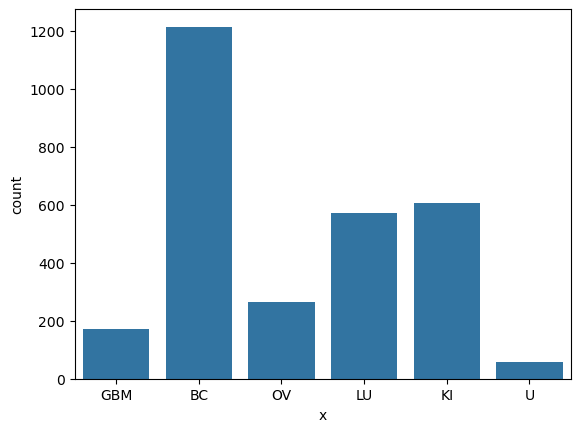

In [124]:
# hist of the class labels
sns.countplot(data=Y, x='x')

In [125]:
# PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled = X

pca = PCA(n_components=2000)  
principal_components = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_

cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance_ratios)

n_components_80 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 1]) + 1
print(f"Number of components needed to explain 50% variance: {n_components_80}")

# Create a DataFrame to store the principal com ponents
# df_components = pd.DataFrame(data=principal_components, columns=['Component 1', 'Component 2'])

# Plot the two principal components
plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, marker='o', linestyle='-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
# plt.grid(True)
# plt.show()

# data_components = pd.concat([df_components, Y], axis=1)
# sns.scatterplot(x='Component 1', y='Component 2', hue='x', data=data_components)

# lineplot of the cumulative explained variance ratio
# plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, marker='o', linestyle='-')

[0.10393918 0.18858025 0.24557156 ... 1.         1.         1.        ]
Number of components needed to explain 50% variance: 1983


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Axes: >

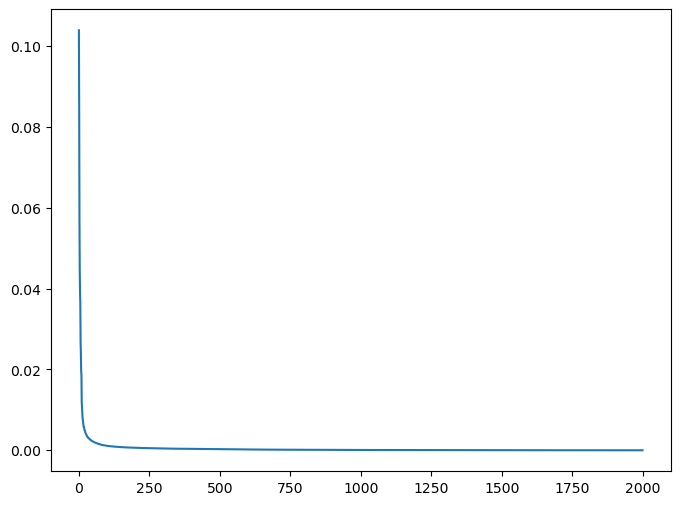

In [126]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=pca.explained_variance_ratio_)

In [127]:
Y['x'].unique()

array(['GBM', 'BC', 'OV', 'LU', 'KI', 'U'], dtype=object)

In [128]:
# assingn a numbered label for Y
label_map = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y['x'] = Y['x'].map(label_map)

In [129]:
Y

,x
1,0
2,0
3,0
4,0
5,0
...,...
2883,5
2884,5
2885,5
2886,5


In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


parameters = {
    'pca__n_components': [2000, 1000, 500, 100, 50, 10],
    'knn__n_neighbors': [1, 2, 5, 10, 50, 100, 300]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])


grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring="balanced_accuracy")

Y = np.ravel(Y)

grid_search.fit(X, Y)
print(grid_search.best_params_)

{'knn__n_neighbors': 1, 'pca__n_components': 50}


In [ ]:
print(X.shape)

In [117]:
# plot the best model
grid_search.best_estimator_


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=50)),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

In [131]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = grid_search.predict(X)

print(classification_report(Y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00      1215
           2       1.00      1.00      1.00       266
           3       1.00      1.00      1.00       571
           4       1.00      1.00      1.00       606
           5       1.00      1.00      1.00        57

    accuracy                           1.00      2887
   macro avg       1.00      1.00      1.00      2887
weighted avg       1.00      1.00      1.00      2887



## Question 2

In [137]:
# Create the RFECV model
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


classifier = KNeighborsClassifier(n_neighbors=50)
rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1, importance_getter='identity', min_features_to_select=10)

# Create a pipeline with scaling and feature selection
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('feature_selection', rfecv)])

# Fit the model
pipeline.fit(X, Y)

# Number of best features
optimal_feature_count = rfecv.n_features_

print(f"Optimal number of features : {optimal_feature_count}")

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

AttributeError: 'KNeighborsClassifier' object has no attribute 'identity'